In [11]:
# %%
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString
import geopandas as gpd

%matplotlib inline
print("✅ Llibreries carregades")

# Carreguem una xarxa més gran per tenir espai
area = "Gràcia, Barcelona, Spain"
G = ox.graph_from_place(area, network_type='walk', simplify=True)
G_proj = ox.project_graph(G)  # Projectem a metres per treballar en distàncies reals

print(f"Nodes: {len(G.nodes())}, Vores: {len(G.edges())}")

✅ Llibreries carregades
Nodes: 4851, Vores: 15596


Centre: (429268.7, 4584553.8)
Radi: 500 metres


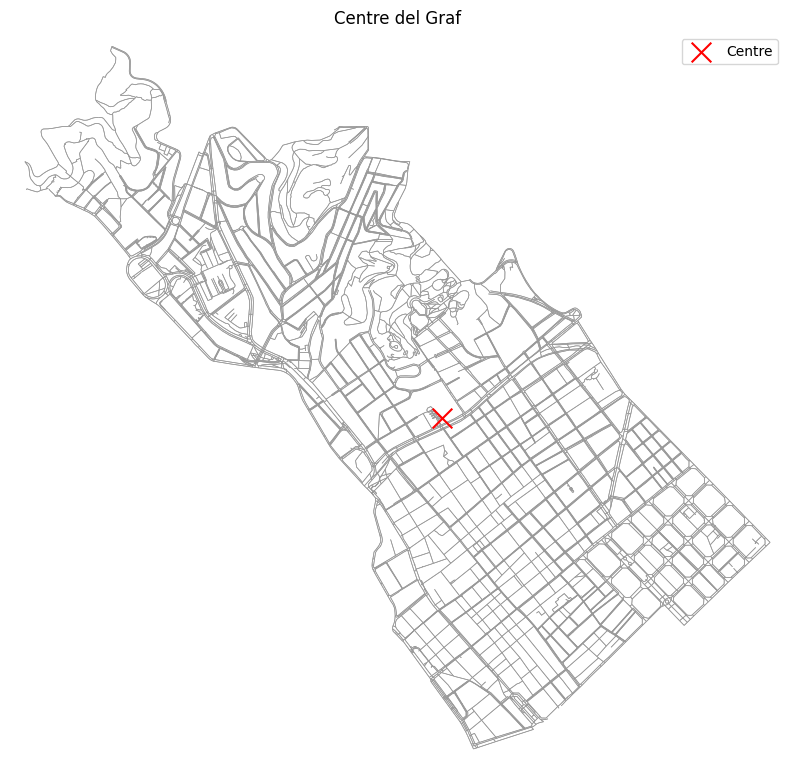

In [12]:
# %%
# Calculem el centre del graf
nodes = list(G_proj.nodes())
coords = np.array([(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in nodes])
center_x, center_y = coords.mean(axis=0)

# Radi en metres (aprox 300m)
radius_m = 500

print(f"Centre: ({center_x:.1f}, {center_y:.1f})")
print(f"Radi: {radius_m} metres")

# Visualitzem el centre
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.5, ax=ax, show=False)
ax.scatter(center_x, center_y, color='red', s=200, marker='x', label='Centre')
ax.legend()
ax.set_title("Centre del Graf")
plt.show()

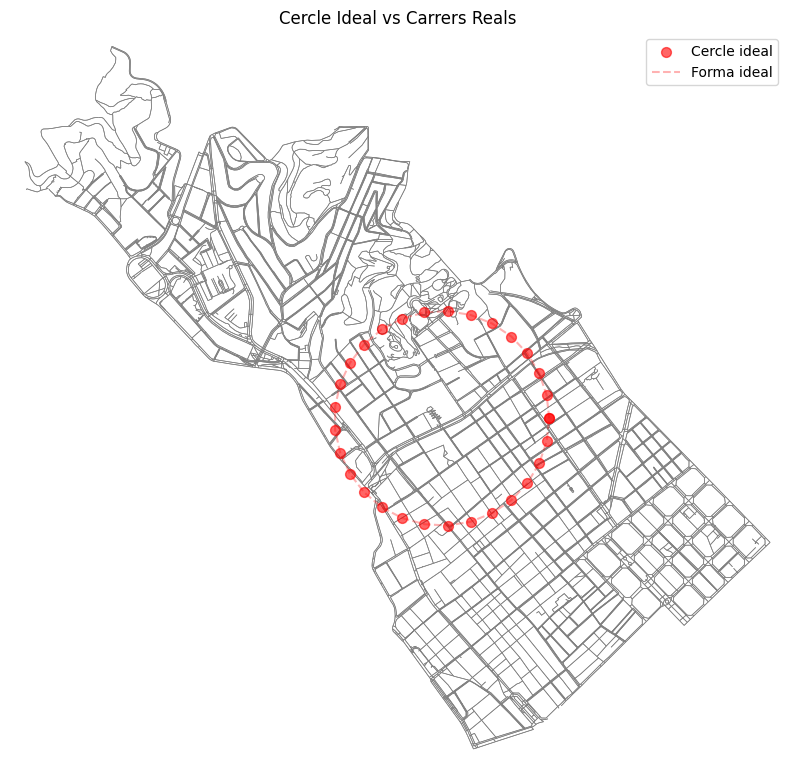

In [13]:
# %%
# Generem 30 punts que formen un cercle
n_points = 30
angles = np.linspace(0, 2*np.pi, n_points)

# Punts del cercle ideal (en el sistema projectat)
circle_points = []
for angle in angles:
    x = center_x + radius_m * np.cos(angle)
    y = center_y + radius_m * np.sin(angle)
    circle_points.append((x, y))

circle_points = np.array(circle_points)

# Visualització
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.5, ax=ax, show=False, edge_color='gray')

# Punts del cercle ideal
ax.scatter(circle_points[:, 0], circle_points[:, 1], 
           color='red', s=50, alpha=0.6, label='Cercle ideal')

# Connectem els punts per veure la forma
ax.plot(circle_points[:, 0], circle_points[:, 1], 
        'r--', alpha=0.3, label='Forma ideal')

ax.legend()
ax.set_title("Cercle Ideal vs Carrers Reals")
plt.show()

Distàncies mitjanes dels punts als carrers: 28.7 m
Màxima distància: 75.5 m


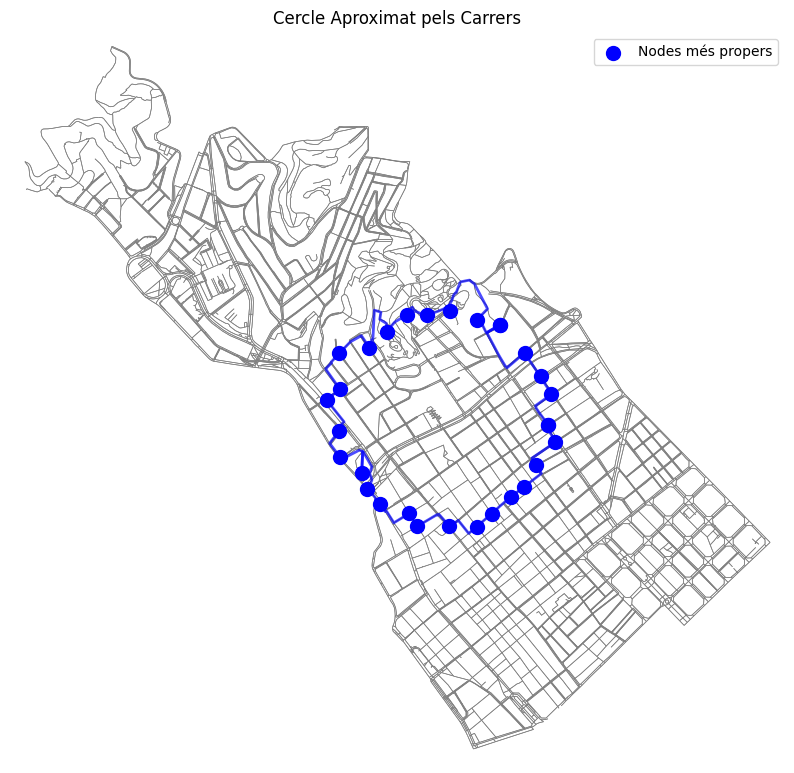

In [14]:
# %%
# Funció per trobar el node més proper a un punt
def find_nearest_node(graph, point):
    """Troba el node més proper a un punt (x, y) en el graf projectat"""
    nodes = list(graph.nodes())
    node_coords = np.array([(graph.nodes[n]['x'], graph.nodes[n]['y']) for n in nodes])
    
    # Calcula distàncies
    distances = np.sqrt((node_coords[:, 0] - point[0])**2 + 
                       (node_coords[:, 1] - point[1])**2)
    
    nearest_idx = np.argmin(distances)
    nearest_node = nodes[nearest_idx]
    distance = distances[nearest_idx]
    
    return nearest_node, distance

# Mapejem cada punt del cercle al node més proper
nearest_nodes = []
distances = []

for point in circle_points:
    node, dist = find_nearest_node(G_proj, point)
    nearest_nodes.append(node)
    distances.append(dist)

print(f"Distàncies mitjanes dels punts als carrers: {np.mean(distances):.1f} m")
print(f"Màxima distància: {np.max(distances):.1f} m")

# Visualització
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.5, ax=ax, show=False, edge_color='gray')

# Nodes trobats
node_coords = [(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in nearest_nodes]
node_coords = np.array(node_coords)

ax.scatter(node_coords[:, 0], node_coords[:, 1], 
           color='blue', s=100, label='Nodes més propers')

# Connectem els nodes en ordre
for i in range(len(nearest_nodes)-1):
    # Obtenim les coordenades dels nodes
    node1 = nearest_nodes[i]
    node2 = nearest_nodes[i+1]
    
    # Busquem el camí més curt entre ells
    try:
        path = nx.shortest_path(G_proj, node1, node2, weight='length')
        
        # Dibuixem el camí
        path_coords = [(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in path]
        path_coords = np.array(path_coords)
        ax.plot(path_coords[:, 0], path_coords[:, 1], 'b-', alpha=0.7, linewidth=2)
    except nx.NetworkXNoPath:
        print(f"No hi ha camí entre {node1} i {node2}")

# Tancar el cercle (últim node amb el primer)
try:
    path = nx.shortest_path(G_proj, nearest_nodes[-1], nearest_nodes[0], weight='length')
    path_coords = [(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in path]
    path_coords = np.array(path_coords)
    ax.plot(path_coords[:, 0], path_coords[:, 1], 'b-', alpha=0.7, linewidth=2)
except:
    print("No es pot tancar el cercle")

ax.set_title("Cercle Aproximat pels Carrers")
ax.legend()
plt.show()

Distància total aproximada: 5060 metres
Nodes a la ruta: 186


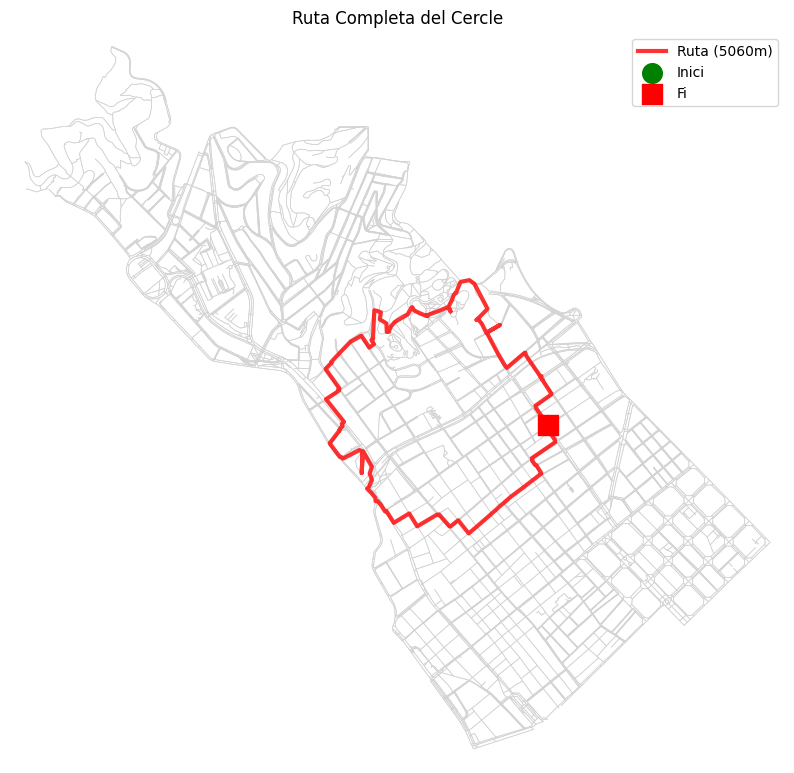

In [15]:
# %%
# Construïm la ruta completa connectant tots els nodes
full_route = []
total_distance = 0

for i in range(len(nearest_nodes)):
    node1 = nearest_nodes[i]
    node2 = nearest_nodes[(i+1) % len(nearest_nodes)]  # Mòdul per tancar cercle
    
    try:
        path = nx.shortest_path(G_proj, node1, node2, weight='length')
        
        # Afegim el camí (evitant duplicar nodes)
        if full_route:
            full_route.extend(path[1:])  # No dupliquem el primer node
        else:
            full_route.extend(path)
        
        # Calculem la distància d'aquest segment
        segment_dist = nx.shortest_path_length(G_proj, node1, node2, weight='length')
        total_distance += segment_dist
        
    except nx.NetworkXNoPath:
        print(f"⚠️ No hi ha camí entre node {i} i {i+1}")
        # En aquest cas, podríem saltar aquest segment o buscar alternativa

print(f"Distància total aproximada: {total_distance:.0f} metres")
print(f"Nodes a la ruta: {len(full_route)}")

# Visualització de la ruta completa
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G_proj, node_size=0, edge_linewidth=0.5, ax=ax, show=False, edge_color='lightgray')

# Dibuixem la ruta
if full_route:
    route_coords = [(G_proj.nodes[n]['x'], G_proj.nodes[n]['y']) for n in full_route]
    route_coords = np.array(route_coords)
    
    ax.plot(route_coords[:, 0], route_coords[:, 1], 
            'r-', linewidth=3, alpha=0.8, label=f'Ruta ({total_distance:.0f}m)')
    
    # Punts d'inici/fi
    ax.scatter(route_coords[0, 0], route_coords[0, 1], 
               color='green', s=200, marker='o', label='Inici')
    ax.scatter(route_coords[-1, 0], route_coords[-1, 1], 
               color='red', s=200, marker='s', label='Fi')

ax.legend()
ax.set_title("Ruta Completa del Cercle")
plt.show()

Ruta amb 186 punts geogràfics


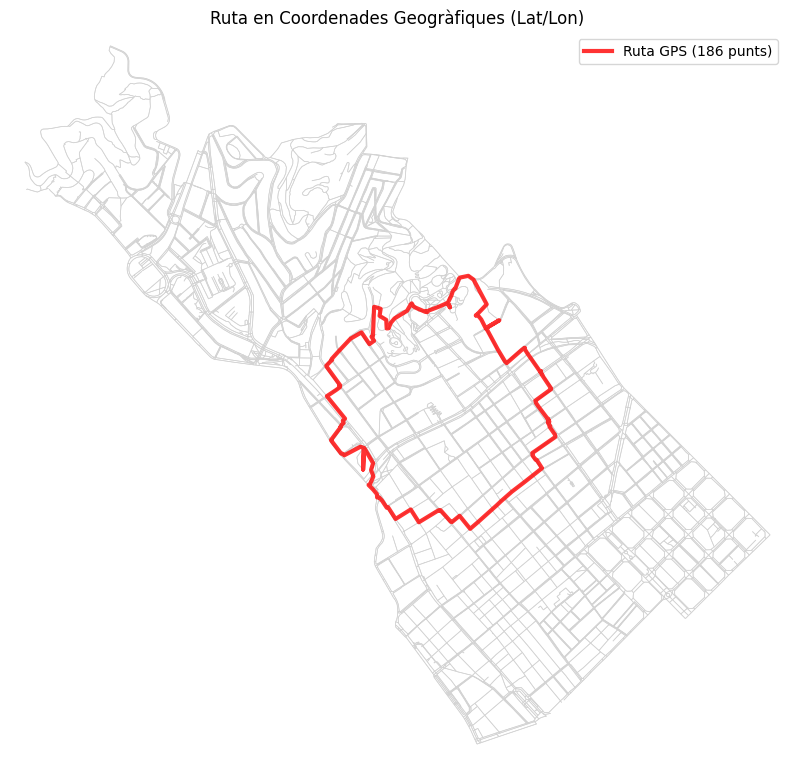

In [16]:
# %%
# Convertim els nodes de la ruta de tornada a coordenades geogràfiques
route_nodes = full_route

# Obtenim les coordenades geogràfiques originals (lat, lon) del graf original
route_coords_geo = []
for node in route_nodes:
    # El graf original G té les coordenades en lat/lon
    lat = G.nodes[node]['y']
    lon = G.nodes[node]['x']
    route_coords_geo.append((lat, lon))

print(f"Ruta amb {len(route_coords_geo)} punts geogràfics")

# Creem un objecte LineString per a la ruta
route_line = LineString([Point(lon, lat) for lat, lon in route_coords_geo])

# Visualització final en coordenades geogràfiques
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G, node_size=0, edge_linewidth=0.5, ax=ax, show=False, edge_color='lightgray')

# Dibuixem la ruta
if route_coords_geo:
    lats, lons = zip(*route_coords_geo)
    ax.plot(lons, lats, 'r-', linewidth=3, alpha=0.8, 
            label=f'Ruta GPS ({len(route_coords_geo)} punts)')

ax.legend()
ax.set_title("Ruta en Coordenades Geogràfiques (Lat/Lon)")
plt.show()

In [17]:
# %%
try:
    import gpxpy
    import gpxpy.gpx
    
    # Creem el fitxer GPX
    gpx = gpxpy.gpx.GPX()
    
    # Creem una track
    gpx_track = gpxpy.gpx.GPXTrack()
    gpx.tracks.append(gpx_track)
    
    # Creem un segment
    gpx_segment = gpxpy.gpx.GPXTrackSegment()
    gpx_track.segments.append(gpx_segment)
    
    # Afegim punts de la ruta
    for lat, lon in route_coords_geo:
        gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(lat, lon))
    
    # Guardem a fitxer
    gpx_filename = "ruta_cercle_barcelona.gpx"
    with open(gpx_filename, 'w') as f:
        f.write(gpx.to_xml())
    
    print(f"✅ Fitxer GPX guardat: {gpx_filename}")
    print(f"   - Punts: {len(route_coords_geo)}")
    print(f"   - Distància aproximada: {total_distance:.0f} m ({total_distance/1000:.2f} km)")
    
except ImportError:
    print("⚠️ gpxpy no instal·lat. Instal·la amb: pip install gpxpy")
    print("   Per ara, mostrem les coordenades:")
    for i, (lat, lon) in enumerate(route_coords_geo[:5]):  # Primeres 5
        print(f"   {i}: {lat:.6f}, {lon:.6f}")
    print("   ...")

✅ Fitxer GPX guardat: ruta_cercle_barcelona.gpx
   - Punts: 186
   - Distància aproximada: 5060 m (5.06 km)
